In [44]:
import numpy as np
from astropy.table import Table
import thecannon as tc
import matplotlib.pyplot as p
from matplotlib.colors import LogNorm
# from mpi4py import MPI
# import multiprocess as mp

# comm = MPI.COMM_WORLD
# rank = comm.Get_rank()

## Let's start by training and testing only on giants with modest reddening (logg<3, Teff<5500K, A_v < 1)

Currently training on mock BP RP spectra from Maddie.  Ultimately, we will want to train directly on the Hermite coefficient matrices to save time.

In [4]:
#paths
table_path = '/Users/catherinemanea/Documents/BP_RP/apogee_bprp_params/apogee_bprp_params/'
spec_path = '/Users/catherinemanea/Documents/BP_RP/apogee_bprp_params/apogee_bprp_params/' #assumes spec are in directory 'apogee' inside this path
fig_path = '/Users/catherinemanea/Documents/BP_RP/apogee_bprp_params/apogee_bprp_params/'

Load in labels:

In [5]:
t = Table.read(table_path+'synth_apogee_0.fits')
t = t[t['synth']]

Load in spectra:

In [10]:
#loading in spec with max normalization
size = len(t) #adjust if you only want to play with subset of data

for i in range(size):
    if i%1000 == 0:
        print(str(np.round(100*i/size, 2))+'%', end='    \r')
    Teff = t['Teff'][i] ; logg = t['logg'][i] ; feh = t['feh'][i] ;  a = t['A_v'][i] ; s = t['SNR'][i]
    filename = '%s_g%s_f%s_a%s_n%s.txt'%(str(Teff),str(logg),str(feh),str(a),str(s))
    try:
        w, fbp, ebp = np.loadtxt(spec_path+'apogee/Bp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
        wr, frp, erp = np.loadtxt(spec_path+'apogee/Rp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
       
    except:  
        try:
            formatter = "{0:.12g}"
            Teff2 = formatter.format(Teff)
            logg2 = formatter.format(logg)
            feh2 = formatter.format(feh)
            s2 = formatter.format(s)
            a2 = formatter.format(a)
            filename = '%s_g%s_f%s_a%s_n%s.txt'%(str(Teff2),str(logg2),str(feh2),str(a2),str(s2))
            w, fbp, ebp = np.loadtxt(spec_path+'apogee/Bp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
            wr, frp, erp = np.loadtxt(spec_path+'apogee/Rp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
            
        except:
            try:
                formatter = "{0:.12g}"
                logg2 = formatter.format(logg)
                feh2 = formatter.format(feh)
                s2 = formatter.format(s)
                a2 = formatter.format(a)
                filename = '%s_g%s_f%s_a%s_n%s.txt'%(str(Teff),str(logg2),str(feh2),str(a2),str(s2))
                w, fbp, ebp = np.loadtxt(spec_path+'apogee/Bp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
                wr, frp, erp = np.loadtxt(spec_path+'apogee/Rp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
                
            except:
                formatter = "{0:.12g}"
                Teff2 = formatter.format(Teff)
                logg2 = formatter.format(logg)
                feh2 = formatter.format(feh)
                a2 = formatter.format(a)
                s = "{0:.1f}".format(s)
                filename = '%s_g%s_f%s_a%s_n%s.txt'%(str(Teff2),str(logg2),str(feh2),str(a2),str(s))
                w, fbp, ebp = np.loadtxt(spec_path+'apogee/Bp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
                wr, frp, erp = np.loadtxt(spec_path+'apogee/Rp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)

    w = w[~np.isnan(ebp)]
    wr = wr[~np.isnan(erp)]
    fbp = fbp[~np.isnan(ebp)]
    ebp = ebp[~np.isnan(ebp)]
    frp = frp[~np.isnan(erp)]
    erp = erp[~np.isnan(erp)]
    
    if i == 0:
        xs = np.zeros((len(t[:size]),len(np.concatenate([fbp,frp]))))
        bps = np.zeros((len(t[:size]),len(fbp)))
        rps = np.zeros((len(t[:size]),len(frp)))
        xerrs = np.zeros((len(t[:size]),len(np.concatenate([fbp,frp]))))
        standard_errs = np.zeros((len(t[:size]),len(np.concatenate([fbp,frp]))))
    
    f = np.concatenate([fbp,frp])
    errs = 1.0/np.sqrt(np.concatenate([ebp,erp])/np.max(f))
    xs[i,:] = f/np.max(f)
    bps[i,:] = fbp/np.max(fbp)
    rps[i,:] = frp/np.max(frp)
    xerrs[i,:] = errs
    standard_errs[i,:] = np.concatenate([ebp,erp])/np.max(f)
    wf = np.concatenate([w,wr])
    

Define subset of data for training and testing (uncomment relevant cell):

In [131]:
# # **Giants**

# subset = np.where((t['Teff'] < 5500) & (t['logg'] < 3) & (t['A_v'] < 1) & (t['A_v'] > 0))
# t_subset = t[subset]
# xs_subset = xs[subset]
# xerrs_subset = xerrs[subset]

In [255]:
# # **Giants and Less Restrictive A_v

# subset = np.where((t['Teff'] < 5500) & (t['logg'] < 3) & (t['A_v'] < 3) & (t['A_v'] > 0))
# t_subset = t[subset]
# xs_subset = xs[subset]
# xerrs_subset = xerrs[subset]

In [272]:
# # **DWARFS**

# subset = np.where((t['Teff'] < 6500) & (t['Teff'] > 4500) & (t['logg'] > 4) & (t['A_v'] < 1) & (t['A_v'] > 0))
# t_subset = t[subset]
# xs_subset = xs[subset]
# xerrs_subset = xerrs[subset]

In [288]:
# **Dwarfs+Giants**

subset = np.where((t['Teff'] < 6500) & (t['A_v'] < 1) & (t['A_v'] > 0))
t_subset = t[subset]
xs_subset = xs[subset]
xerrs_subset = xerrs[subset]

Separate training and testing sets, reassign NaN and inf values:

In [289]:
#making training and testing sets
# train_inds = np.random.choice(range(len(t)),int(.6*len(t)),replace=False)
# test_inds = np.array(list(set(range(len(t)))- set(train_inds)),dtype='int')
print(len(t), len(t[subset]))

np.random.seed(777) # For reproducibility.
q = np.random.randint(0, 10, len(t_subset)) % 10
validate_set = np.where((q<=2))[0]
train_set = np.where((q>2))[0]
train_inds = train_set
test_inds = validate_set

train_xs = xs_subset[train_inds]
train_errs = xerrs_subset[train_inds]
bad = np.where(np.isnan(train_xs))
train_xs[bad] = 0.0000001
bad = np.where(np.isnan(train_errs))
train_errs[bad] = 0.0000001
bad = np.where(train_xs==np.inf)
train_xs[bad] = 1e6
bad = np.where(train_errs==np.inf)
train_errs[bad] = 1e6

test_xs = xs_subset[test_inds]
test_errs = xerrs_subset[test_inds]
bad = np.where(np.isnan(test_xs))
test_xs[bad] = 0.0000001
bad = np.where(np.isnan(test_errs))
test_errs[bad] = 0.0000001
bad = np.where(test_xs==np.inf)
test_xs[bad] = 1e6
bad = np.where(test_errs==np.inf)
test_errs[bad] = 1e6

train_t = t_subset[train_inds]
test_t = t_subset[test_inds]

print(len(train_t), len(test_t))

62074 27171
19044 8127


Plot some spectra just to see what they look like:

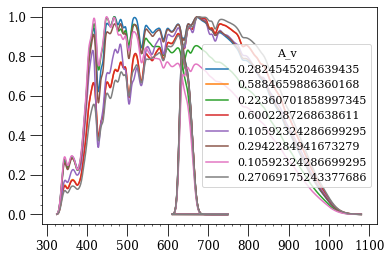

In [290]:
teffs = t_subset['Teff']
loggs = t_subset['logg']
fehs = t_subset['feh']
avs = t_subset['A_v']
snrs = t_subset['SNR']

#plot a few spectra
p.figure()
N=1
for i in range(8):
    p.plot(wf, xs_subset[i], label=t_subset['A_v'][i])
p.legend(title="A_v")
p.show()

Specify vectorizer, set up and train the model:

In [297]:
# # Specify the vectorizer.
# vectorizer = tc.vectorizer.PolynomialVectorizer(("Teff", "logg", "feh", "A_v"), 2)
# # set up model
# model = tc.CannonModel(train_t, train_xs, train_errs,
#                        vectorizer=vectorizer, dispersion=wf)


vectorizer = tc.vectorizer.PolynomialVectorizer(("Teff", "logg", "feh", "A_v"), 3)

model = tc.CannonModel(train_t, train_xs, train_errs,
    dispersion=wf, vectorizer=vectorizer)
# # No regularization.
model.regularization = 5

# Train the model!
model.train()


2022-05-31 17:54:41,279 [INFO] Training 4-label CannonModel with 19044 stars and 897 pixels/star
stty: 2022-05-31 17:54:41,311 [DEBUG] Couldn't get screen size. Progressbar may look odd.
stdin isn't a terminal


[================                                                                                    ]  15% (133/897; ~3m until finished)     

2022-05-31 17:55:15,476 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  25% (222/897; ~3m until finished)

2022-05-31 17:55:32,618 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================                                           ]  51% (460/897; ~2m until finished)

2022-05-31 17:56:48,236 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================                                          ]  53% (471/897; ~2m until finished)

2022-05-31 17:56:51,764 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  70% (626/897; ~1m until finished)

2022-05-31 17:57:29,113 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================================]  91% (816/897)                          

2022-05-31 17:58:20,535 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================================================] 100% (259s)                             


(array([[ 1.00818702e-03,  1.43242161e-03,  5.43800046e-04, ...,
          2.20362343e-04,  2.62030451e-10,  3.87520722e-09],
        [ 1.95712143e-03,  2.79384202e-03,  1.04196449e-03, ...,
          5.16377042e-04,  9.67974394e-09, -3.28588737e-08],
        [ 3.58451297e-03,  5.12631486e-03,  1.89070800e-03, ...,
          1.03047132e-03, -1.15255046e-10,  5.97353821e-13],
        ...,
        [ 3.09709567e-04, -1.86636614e-04,  1.39477457e-06, ...,
         -2.24674493e-09,  1.99003286e-09, -1.55288422e-08],
        [ 2.68944244e-04, -1.60917494e-04,  1.59903094e-06, ...,
         -3.36700431e-16,  9.58430363e-16, -5.18241431e-17],
        [ 2.31074693e-04, -1.37839754e-04,  9.65432717e-07, ...,
         -4.91974249e-13, -2.30643818e-12,  2.36161425e-13]]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 

Test the model:

In [298]:
#infer for train
test_labels, cov, metadata = model.test(test_xs, test_errs)


#fig_comparison = tc.plot.one_to_one(model, test_labels, latex_label_names=[r"T_{\rm eff}",r"\log{g}",r"[{\rm Fe}/{\rm H}]",r"{\rm A_V}"])
#fig_comparison.savefig(fig_path+"one-to-one.png", dpi=300)

stty: stdin isn't a terminal2022-05-31 17:59:01,594 [DEBUG] Couldn't get screen size. Progressbar may look odd.

2022-05-31 17:59:01,598 [INFO] Running test step on 8127 spectra


[====================================================================================================] 100% (256s)                               


Plot difference between true and inferred values:

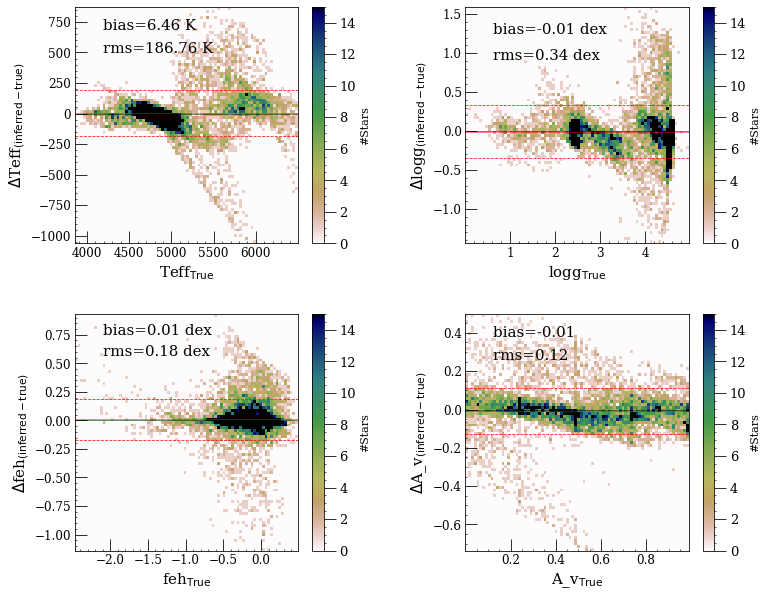

In [299]:
font = {'family' : 'serif',
        'weight' : 'regular',
        'size'   : 11}

import matplotlib
fig, axs = p.subplots(2,2,figsize=(12,10))
fig.subplots_adjust(hspace=0.3, wspace=0.4)
p.rc('font', **font)
p.rcParams['xtick.major.size'] = 12
p.rcParams['xtick.labelsize'] = 12
p.rcParams['ytick.major.size'] = 12
p.rcParams['ytick.labelsize'] = 12
p.rcParams["ytick.minor.visible"] =  True
p.rcParams["xtick.minor.visible"] =  True

    
unit = ['K', 'dex', 'dex', '']
for i, param in enumerate(['Teff', 'logg', 'feh', 'A_v']):
    ax = np.ravel(axs)[i]
    h = ax.hist2d(t_subset[param][test_inds],test_labels[:,i] - t_subset[param][test_inds], bins=80,  cmap='gist_earth_r', vmin=0, vmax=15)
    ax.axhline(y=0, c='k', alpha=.99, lw=.5)
    bias = np.round(np.mean(test_labels[:,i] - t_subset[param][test_inds]), 2)
    rms = np.round(np.std(test_labels[:,i] - t_subset[param][test_inds]), 2)
    ax.axhline(y=bias, c='r', alpha=.9, lw=.5)
    ax.axhline(y=bias+rms, c='r', alpha=.9, lw=.8, ls='--')
    ax.axhline(y=bias-rms, c='r', alpha=.9, lw=.8, ls='--')
    offset = (np.max(t_subset[param][test_inds]) - np.min(t_subset[param][test_inds]))/8
    ax.text(offset+np.min(t_subset[param][test_inds]), np.max(test_labels[:,i] - t_subset[param][test_inds])-rms, "bias={a} {b}".format(a=bias, b=unit[i]), fontsize=15)
    ax.text(offset+np.min(t_subset[param][test_inds]), np.max(test_labels[:,i] - t_subset[param][test_inds])-(2*rms), "rms={a} {b}".format(a=rms, b=unit[i]), fontsize=15)
    #ax.text(0.1, 0.8, "rms={}".format(rms))
    cbar = fig.colorbar(h[3], ax=ax, label='#Stars')
    cbar.ax.tick_params(labelsize=13) 
    #ax.set_title(param)
    ax.set_xlabel(param+r"$\rm _{{}True{}}$", fontsize=15)
    ax.set_ylabel(r"$\rm \Delta$"+param+r"$\rm _{(inferred - true)}$", fontsize=15)
    ax.tick_params(axis="both", which='both', direction="in")
p.savefig("Diagnostic_Figs/inferred_vs_true_everything_hist2d_regularization5_poly3.pdf")

# Ignore below

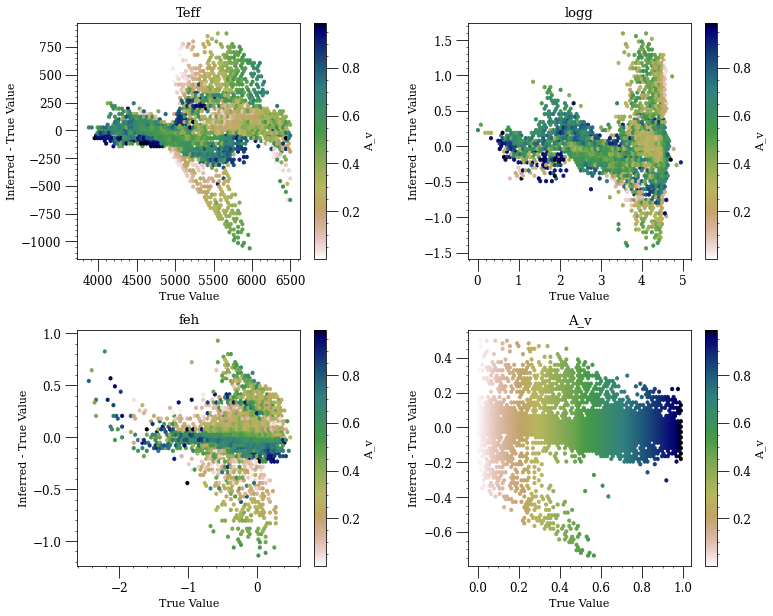

In [300]:
fig, axs = p.subplots(2,2,figsize=(12,10))
fig.subplots_adjust(hspace=0.3, wspace=0.4)
for i, param in enumerate(['Teff', 'logg', 'feh', 'A_v']):
    ax = np.ravel(axs)[i]
    h = ax.hexbin(t_subset[param][test_inds],test_labels[:,i] - t_subset[param][test_inds], gridsize=70, C=t_subset['A_v'][test_inds], cmap='gist_earth_r')
    fig.colorbar(h, ax=ax, label='A_v')
    ax.set_title(param)
    ax.set_xlabel("True Value")
    ax.set_ylabel("Inferred - True Value")
p.savefig("Diagnostic_Figs/inferred_vs_true_dwarfs+giants_colorAv.pdf")

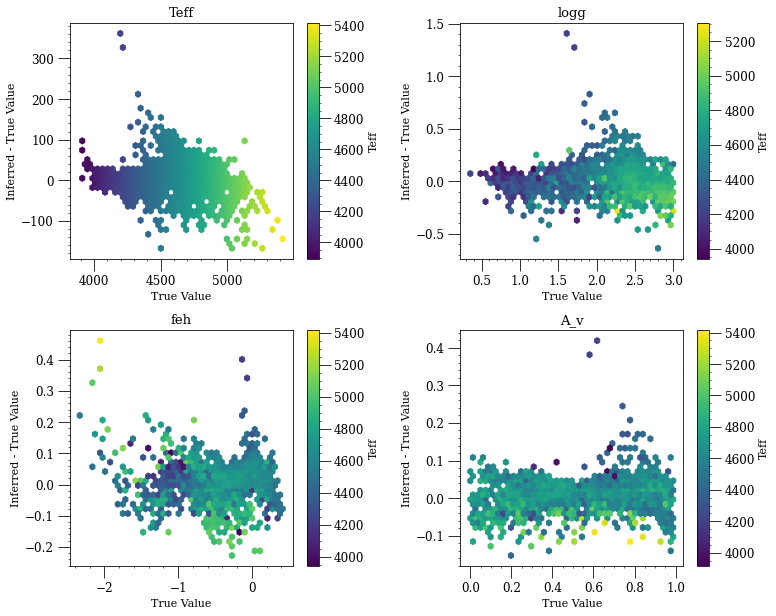

In [246]:
fig, axs = p.subplots(2,2,figsize=(12,10))
fig.subplots_adjust(hspace=0.3, wspace=0.4)
for i, param in enumerate(['Teff', 'logg', 'feh', 'A_v']):
    ax = np.ravel(axs)[i]
    h = ax.hexbin(t_subset[param][test_inds],test_labels[:,i] - t_subset[param][test_inds], gridsize=40, C=t_subset['Teff'][test_inds])
    fig.colorbar(h, ax=ax, label='Teff')
    ax.set_title(param)
    ax.set_xlabel("True Value")
    ax.set_ylabel("Inferred - True Value")
p.savefig("Diagnostic_Figs/inferred_vs_true_giants_colorTeff.pdf")

Histograms of inferred and true values

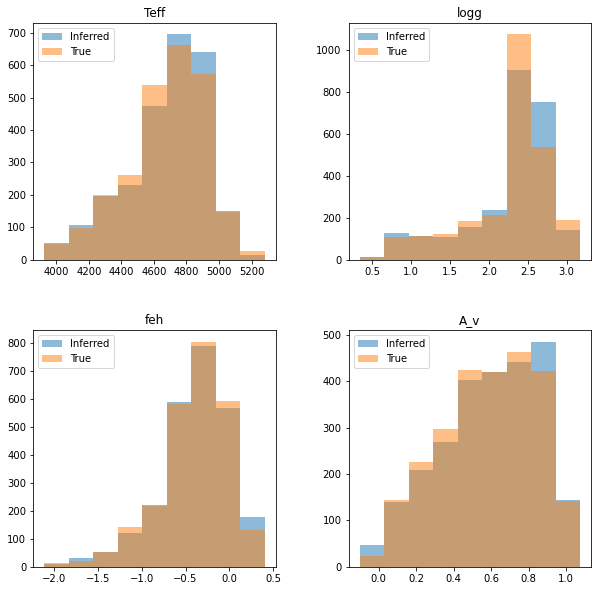

In [82]:
fig, axs = p.subplots(2,2,figsize=(10,10))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i, param in enumerate(['Teff', 'logg', 'feh', 'A_v']):
    ax = np.ravel(axs)[i]
    ax.hist(test_labels[:,i], alpha=.5, label='Inferred', bins=np.linspace(np.min(test_labels[:,i]), np.max(test_labels[:,i]), 10))
    ax.hist(t_subset[param][test_inds], alpha=.5, label='True', bins=np.linspace(np.min(test_labels[:,i]), np.max(test_labels[:,i]), 10))
    ax.set_title(param)
    ax.legend()

In [22]:
print(np.mean(test_labels[:,0]))
print(np.mean(np.abs(test_labels[:,0]-t_subset['Teff'][test_inds])))
print(np.mean(np.abs(test_labels[:,1]-t_subset['logg'][test_inds])))
print(np.mean(t_subset['Teff'][test_inds]))

4713.514115503945
133.1570589247056
0.23250657097173905
4673.8448497928375


In [14]:
print(np.min(t_subset['Teff'][test_inds]), np.max(t_subset['Teff'][test_inds]))
print(np.min(t_subset['Teff'][train_inds]), np.max(t_subset['Teff'][train_inds]))

4500.07275390625 6499.94677734375
4500.07666015625 6499.4990234375


In [24]:
# def func1():
#     print('func1: starting')
#     for i in xrange(10000000): pass
#     print('func1: finishing')

# def func2():
#     print('func2: starting')
#     for i in xrange(10000000): pass
#     print('func2: finishing')

# p1 = Process(target=func1)
# p1.start()
# p2 = Process(target=func2)
# p2.start()
# p1.join()
# p2.join()

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/envs/p38/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/anaconda3/envs/p38/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'func1' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/envs/p38/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/anaconda3/envs/p38/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'func2' on <module '__main__' (built-in)>
